In [7]:
import numpy as np
from scipy.fft import fftn, ifftn, fftshift, ifftshift
import matplotlib.pyplot as plt

np.random.seed(42)

# Image Creation

In [6]:
def create_plane_at_location(shape, location, plane='xy'):
    """
    Create a 3D array with all elements set to 0, except for a plane of pixels
    intersecting a specific pixel location, where the plane's pixels are set to 1.
    
    :param shape: tuple of 3 integers (x, y, z), specifying the shape of the array.
    :param location: tuple of 3 integers (x_loc, y_loc, z_loc), specifying the pixel location.
    :param plane: string specifying the plane to fill with 1s ('xy', 'yz', or 'xz').
    :return: 3D numpy array.
    """
    # Initialize a 3D array with zeros
    array = np.zeros(shape, dtype=int)
    
    x_loc, y_loc, z_loc = location
    
    # Check that the location is valid within the shape
    if not (0 <= x_loc < shape[0] and 0 <= y_loc < shape[1] and 0 <= z_loc < shape[2]):
        raise ValueError("Location is out of bounds for the given shape")
    
    # Set the plane of pixels to 1 based on the specified plane
    if plane == 'xy':
        array[:, :, z_loc] = 1  # All pixels in the xy plane at z_loc
    elif plane == 'yz':
        array[x_loc, :, :] = 1  # All pixels in the yz plane at x_loc
    elif plane == 'xz':
        array[:, y_loc, :] = 1  # All pixels in the xz plane at y_loc
    else:
        raise ValueError("Invalid plane choice. Choose from 'xy', 'yz', or 'xz'.")
    
    return array


def create_binary_array(shape, num_ones):
    """
    Create a 3D binary array where `num_ones` pixels are randomly set to 1, and the rest are 0.
    
    :param shape: tuple of 3 integers (x, y, z), specifying the shape of the array.
    :param num_ones: number of pixels to set to 1.
    :return: 3D numpy array of 0s and 1s.
    """
    # Create an array of zeros
    array = np.zeros(shape, dtype=int)

    # Flatten the array to easily pick random indices
    flat_array = array.ravel()

    # Randomly choose indices to set to 1
    one_indices = np.random.choice(flat_array.size, num_ones, replace=False)

    # Set those indices to 1
    flat_array[one_indices] = 1

    # Reshape the array back to 3D
    return flat_array.reshape(shape)

def create_poisson_array(shape, lam):
    """
    Create a 3D array where pixel values follow a Poisson distribution with a given lambda.
    
    :param shape: tuple of 3 integers (x, y, z), specifying the shape of the array.
    :param lam: lambda parameter for the Poisson distribution (mean number of events).
    :return: 3D numpy array with Poisson-distributed values.
    """
    # Generate a Poisson-distributed array with mean `lam`
    array = np.random.poisson(lam, size=shape)
    
    return array

# Visualization

In [9]:
def visualize_slice(array, title, slice_idx=None):
    """
    Visualize a 2D slice of a 3D array using matplotlib's imshow().
    
    :param array: 3D numpy array.
    :param title: Title of the plot.
    :param slice_idx: The index of the slice along the z-axis (optional). If None, the middle slice is chosen.
    """
    # Choose the middle slice if no slice index is provided
    if slice_idx is None:
        slice_idx = array.shape[2] // 2  # middle slice along z-axis

    # Extract a 2D slice
    slice_2d = array[:, :, slice_idx]

    # Plot the slice
    plt.imshow(slice_2d, cmap='gray')
    plt.title(f'{title} (Slice {slice_idx})')
    plt.colorbar()
    plt.show()
    
def visualize_sum_along_axis(array, axis, index_range, title):
    """
    Visualize a sum of pixels along a given axis of a 3D array between two indices.

    :param array: 3D numpy array.
    :param axis: The axis along which to sum (0, 1, or 2).
    :param index_range: Tuple (start_index, end_index) for the range of indices along the given axis.
    :param title: Title of the plot.
    """
    start_idx, end_idx = index_range

    # Sum along the chosen axis in the given index range
    summed_array = np.sum(array.take(indices=range(start_idx, end_idx), axis=axis), axis=axis)

    # Plot the result
    plt.imshow(summed_array, cmap='gray')
    plt.title(f'{title} (Summed from index {start_idx} to {end_idx} along axis {axis})')
    plt.colorbar()
    plt.show()
    
def visualize_cube(array):
    """
    Visualize a 3D array (cube) using a voxel plot.
    
    :param array: 3D numpy array where values are 0 or 1.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a 3D grid for voxel plotting
    ax.voxels(array, facecolors='blue', edgecolor='k')
    
    # Set labels for axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.title("3D Voxel Visualization")
    plt.show()

# Kernel Generation and Convolution Implementation

In [12]:
def create_kernel(shape):
    """
    Create a 3D kernel with a given shape. 
    In this example, we are creating a simple Gaussian kernel.
    
    :param shape: tuple of 3 integers (x, y, z), specifying the shape of the kernel.
    :return: 3D numpy array representing the kernel.
    """
    x, y, z = np.indices(shape)
    center = np.array(shape) // 2
    sigma = min(shape) / 50.0  # Example: a standard deviation for Gaussian kernel
    print('sigma = ',sigma)

    # Gaussian kernel formula
    kernel = np.exp(-((x - center[0]) ** 2 + (y - center[1]) ** 2 + (z - center[2]) ** 2) / (2 * sigma ** 2))
    
    # Normalize the kernel so that the sum is 1
    return kernel #/ kernel.sum()

def fft_convolve3d_aligned(array, kernel):
    """
    Perform a 3D convolution using FFT, ensuring that the (0,0,0) point of the 
    original array and the convolved result align.
    
    :param array: 3D numpy array representing the input data.
    :param kernel: 3D numpy array representing the kernel to convolve with.
    :return: The result of the convolution with aligned origin (0,0,0).
    """
    # Get the shape of the input array and the kernel
    array_shape = array.shape
    kernel_shape = kernel.shape
    
    # Perform FFT on both the input array and the kernel
    fft_array = fftn(array)
    
    # Shift the kernel so that its center aligns with (0,0,0) in frequency space
    fft_kernel = fftn(ifftshift(kernel), s=array_shape)

    # Multiply in frequency domain and take inverse FFT to get the result
    convolved = ifftn(fft_array * fft_kernel)
    
    # Return the real part of the result to discard small imaginary parts
    return np.real(convolved)

sigma =  1.28


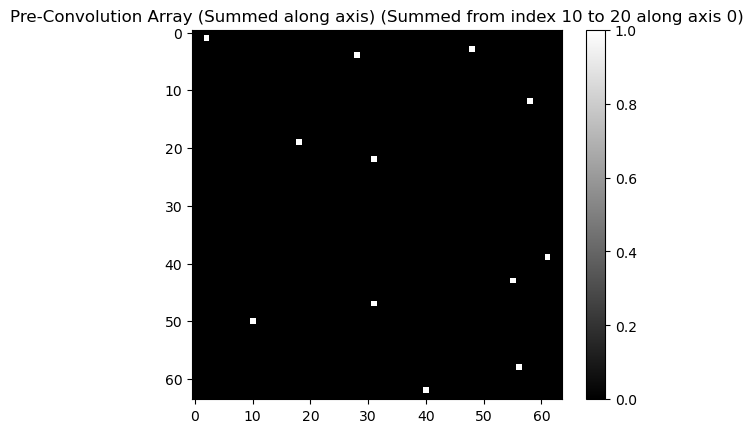

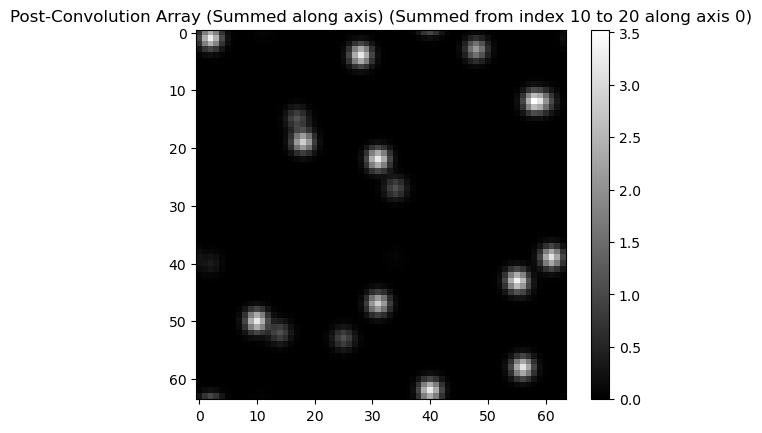

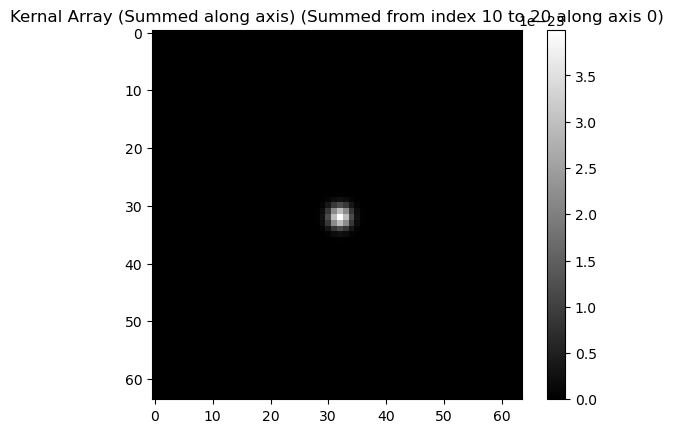

In [15]:
# Example usage:
# Input data: a 3D array of shape that is a power of 2
array_shape = (64,64,64)  # Example shape (must be a power of 2)



# Define the location (x, y, z) for the plane intersection
location = (3,3,3)  # Center of the array
# Create the 3D array with a plane at the specified location in the xy plane
#array = create_plane_at_location(array_shape, location, plane='xy')



# Number of pixels set to 1
num_ones = 100  # Control how many pixels are set to 1
# Create the binary 3D array with random ones
array = create_binary_array(array_shape, num_ones)
# array = create_poisson_array(array_shape, num_ones)


# Lambda (mean) for the Poisson distribution
lam = 1  # You can control the mean value for the Poisson distribution
# Create the Poisson-distributed 3D array
#array = create_poisson_array(array_shape, lam)




# Create the 3D kernel with a shape that is also a power of 2
kernel_shape = (64,64,64)
kernel = create_kernel(kernel_shape)

# Perform the 3D convolution
result = fft_convolve3d_aligned(array, kernel)

## Visualize a slice of the pre-convolved array
#visualize_slice(array, "Pre-Convolution Array (Poisson-distributed)")

# Visualize a sum of pixels along a chosen axis (e.g., axis 2) between two indices
axis = 0  # Choose the axis perpendicular to the slice (0 = x, 1 = y, 2 = z)
index_range = (10,20)  # Choose the range of indices to sum between

# Visualize the summed array from the pre-convolved data
visualize_sum_along_axis(array, axis, index_range, "Pre-Convolution Array (Summed along axis)")

# Visualize a slice of the post-convolved array
#visualize_slice(result, "Post-Convolution Array",slice_idx = 2)
#index_range = (10,20)
visualize_sum_along_axis(result, axis, index_range, "Post-Convolution Array (Summed along axis)")

visualize_sum_along_axis(kernel, axis, index_range, "Kernal Array (Summed along axis)")

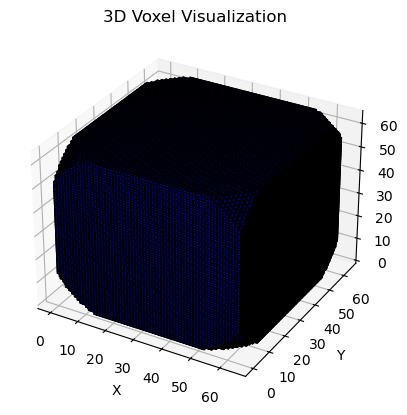

In [16]:
visualize_cube(kernel)